In [24]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from vit_keras import vit, utils
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [28]:
def load_and_process_images(path_dir, class_labels, target_num_images):
    images = []
    labels = []
    min_images = float('inf')
    
    for label, class_name in enumerate(class_labels):
        class_dir = os.path.join(path_dir, class_name)
        class_images = []
        
        if not os.path.exists(class_dir):
            print(f"Directory '{class_name}' not found in '{path_dir}'. Skipping...")
            continue
        
        for jpg in os.listdir(class_dir):
            image_path = os.path.join(class_dir, jpg)
            image_high_resolution = cv2.imread(image_path)
            
            if image_high_resolution is None:
                print(f"Could not read image '{jpg}' in '{class_name}' directory. Skipping...")
                continue
            
            print(f"Reading image '{jpg}' in '{class_name}' directory...")
            image_change_color = cv2.cvtColor(image_high_resolution, cv2.COLOR_BGR2RGB)
            image_low_resolution = cv2.resize(image_change_color, (224, 224))
            class_images.append(image_low_resolution)
        
        num_images = len(class_images)
        if num_images < target_num_images:
            additional_images_required = target_num_images - num_images
            
            print(f"Class '{class_name}' has {num_images} images. {additional_images_required} additional images required to reach the target of {target_num_images} images.")

            # Data augmentation for classes with fewer images than the target
            data_generator = ImageDataGenerator(
                horizontal_flip=True,
                vertical_flip=True,
                rotation_range=270,
                fill_mode='nearest'
            )
            
            augmented_images = []
            for i in range(additional_images_required):
                random_index = np.random.randint(0, num_images)
                augmented_image = data_generator.random_transform(class_images[random_index])
                augmented_images.append(augmented_image)
            
            class_images.extend(augmented_images)
        
        images.extend(class_images[:target_num_images])
        labels.extend([label] * min(target_num_images, len(class_images)))
        min_images = min(min_images, len(class_images))
    
    return np.asarray(images), np.asarray(labels), min_images

dataset_directory = './Datasets/DataImages/'
class_labels = ['Catla', 'Cyprinus carpio', 'Grass Carp', 'Mori', 'Rohu', 'Silver']  
target_num_images = 50 

images, labels, min_images = load_and_process_images(dataset_directory, class_labels, target_num_images)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)



Reading image 'Catla-Body (1).JPG' in 'Catla' directory...
Reading image 'Catla-Body (10).JPG' in 'Catla' directory...
Reading image 'Catla-Body (11).JPG' in 'Catla' directory...
Reading image 'Catla-Body (12).JPG' in 'Catla' directory...
Reading image 'Catla-Body (13).JPG' in 'Catla' directory...
Reading image 'Catla-Body (14).JPG' in 'Catla' directory...
Reading image 'Catla-Body (15).JPG' in 'Catla' directory...
Reading image 'Catla-Body (16).JPG' in 'Catla' directory...
Reading image 'Catla-Body (17).JPG' in 'Catla' directory...
Reading image 'Catla-Body (18).JPG' in 'Catla' directory...
Reading image 'Catla-Body (19).JPG' in 'Catla' directory...
Reading image 'Catla-Body (2).JPG' in 'Catla' directory...
Reading image 'Catla-Body (20).JPG' in 'Catla' directory...
Reading image 'Catla-Body (3).JPG' in 'Catla' directory...
Reading image 'Catla-Body (4).JPG' in 'Catla' directory...
Reading image 'Catla-Body (5).JPG' in 'Catla' directory...
Reading image 'Catla-Body (6).JPG' in 'Catla'

In [33]:
print(y_train.shape)

(240,)


353253686/353253686 [==============================] - 36s 0us/step


C:\Users\POOJYANTH REDDY\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 7, 7
  warnings.warn(


Epoch 1/30


8/8 [==============================] - 18s 1s/step - loss: 2.5856 - accuracy: 0.1292 - val_loss: 1.9555 - val_accuracy: 0.2500
Epoch 2/30
8/8 [==============================] - 10s 1s/step - loss: 2.0360 - accuracy: 0.1708 - val_loss: 1.9262 - val_accuracy: 0.2167
Epoch 3/30
8/8 [==============================] - 10s 1s/step - loss: 1.9304 - accuracy: 0.1875 - val_loss: 1.8540 - val_accuracy: 0.1000
Epoch 4/30
8/8 [==============================] - 10s 1s/step - loss: 1.7861 - accuracy: 0.2500 - val_loss: 1.7407 - val_accuracy: 0.2833
Epoch 5/30
8/8 [==============================] - 10s 1s/step - loss: 1.6861 - accuracy: 0.2958 - val_loss: 1.7913 - val_accuracy: 0.1833
Epoch 6/30
8/8 [==============================] - 10s 1s/step - loss: 1.7375 - accuracy: 0.2417 - val_loss: 1.7640 - val_accuracy: 0.2000
Epoch 7/30
8/8 [==============================] - 10s 1s/step - loss: 1.6997 - accuracy: 0.2833 - val_loss: 1.7352 - val_accuracy: 0.2167
Epoch 8/30
8/8 [================

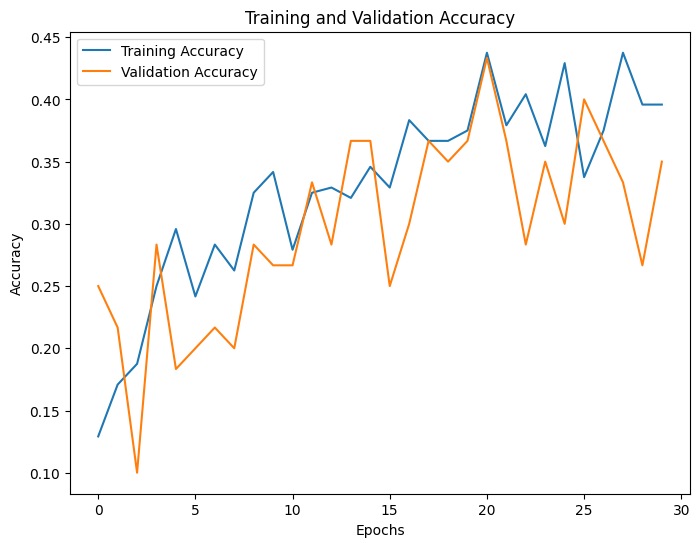

2/2 [==============================] - 2s 879ms/step - loss: 1.5975 - accuracy: 0.3500
Test Accuracy: 35.00%


In [31]:
model = vit.vit_b32(
    image_size=224,  # Adjusted to be a multiple of patch_size
    activation='softmax',
    classes=len(class_labels),
    pretrained=True,
    include_top=False,
    pretrained_top=False,
)

# Freeze the layers in the ViT model
for layer in model.layers:
    layer.trainable = False

# Create a sequential model for fine-tuning
fine_tune_model = models.Sequential([
    model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_labels), activation='softmax')
])

# Compile the model
fine_tune_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = fine_tune_model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_accuracy = fine_tune_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")